## Traveling Salesman Problem (TSP)

Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

Given a connected weighted graph, find the minimum weight Hamiltonian circuit (i.e., a cycle that visits each vertex exactly once).

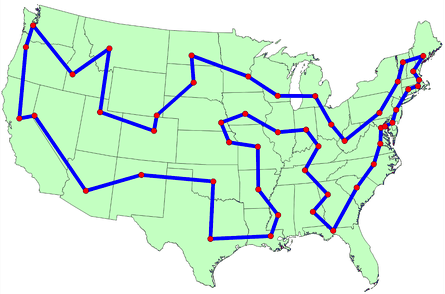

1. Generate $k$ points by creating random $x,y$ coordinates for each; the coordinates will be in the interval $[0,100]$;
2. Assume the graph $G = (V,A)$ on which to solve the TSP is _complete_, i.e. any two pairs are connected by an arc;
3. Create the optimization model for the TSP and solve it on the generated points.

In [ ]:
import numpy as np
import math

k = 7  # number of nodes

grid_size = 100 # size of the grid of points

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
np.random.seed(1337)
point = grid_size * np.random.random((k,2))

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(k)]

# Define the set of edges of the graph as a list of pairs, one for each pair of
# nodes (i,j) in V such that i < j (to avoid duplicate edges and self loops)
E = [(i,j) for i in V for j in V if i < j]

# Determine the euclidean distance between each point
d = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

Let's plot these points on the grid. We use `matplotlib` and specifically the function `matplotlib.pyplot`. We then create a complete graph and draw it on the grid.

In [ ]:
import matplotlib.pyplot as plot
plot.scatter(point[:,0], point[:,1])
plot.show()

We have all data we need and proceed to create a MIP model for the TSP.

### Sets:
 * $V$ is the set of nodes
 * $E$ is the set of edges $(i,j) \in V \times V$

### Parameters:
 * $d_{ij}$ is the cost (or distance) for each $(i,j) \in E$ 

### Variables:
 * $x_{ij} \in \{0,1\}$ is equal to 1 if edge $(i,j)$ is included in the solution path, 0 otherwise

### Model

Try yourself using mip.

In [ ]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

In [ ]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

# TODO

m.optimize()

print(m.objective_value)

Run the following cell to visualize the solution.

In [ ]:
import networkx as nx

def draw_solution(V, A, x):
    g = nx.Graph()

    coord = {i: (point[i,0], point[i,1]) for i in V}

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable x[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.5])
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)

# after defining the function, call it with the current data
draw_solution (V, E, x)

### Real Model

In [ ]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

# 

m.optimize()

print(m.objective_value)
draw_solution (V, E, x)

### Problem: how many constraints are needed?

Need to use $2^k$ constraints (one for each subset of $V$, given that $|V| = k$). This model is not usable in practice.

However, you can start with the model without the subtour-elimination constraints and add them only when needed.

How do we make this automatic? I.e. how do we repeat this step by adding the appropriate subtour-elimination constraint until we find a Hamiltonian circuit?